In [ ]:
import torch
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from torch import nn
print(torch.__version__)

2.1.0+cu121


In [45]:
import requests
from pathlib import Path

#download helper funcs
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
  print("downloaded helper_functions.py")

downloaded helper_functions.py


#4. Toy Dataset

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=32)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f'X: {X[:5]}')
print('\n')
print(f'y: {y[:5]}')

X: [[-0.07257539  0.75564179]
 [-0.5195304   0.53377845]
 [-0.41659803 -0.69048017]
 [-0.64663454  0.67708664]
 [-0.48416281 -0.67039648]]


y: [1 1 1 0 1]


In [ ]:
#convert to pd df
circles_df = pd.DataFrame(X, columns=['X1', 'X2'])
circles_df['label'] = y
circles_df.head()

,X1,X2,label
0,-0.072575,0.755642,1
1,-0.519530,0.533778,1
2,-0.416598,-0.690480,1
3,-0.646635,0.677087,0
4,-0.484163,-0.670396,1


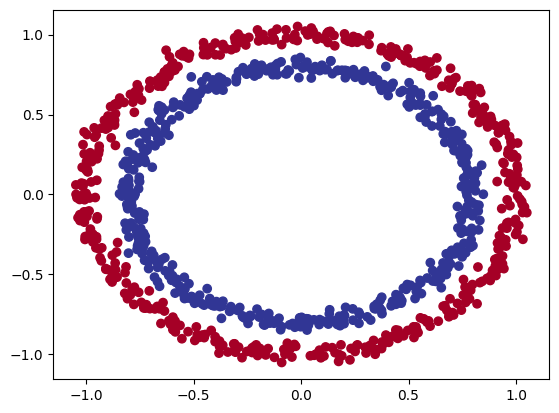

In [ ]:
#visualize
plt.scatter(x=circles_df['X1'],
            y=circles_df['X2'],
            c=y,
            cmap=plt.cm.RdYlBu)

##4.1) data shape

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

##4.2) convert to tensor

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[-0.0726,  0.7556],
         [-0.5195,  0.5338],
         [-0.4166, -0.6905],
         [-0.6466,  0.6771],
         [-0.4842, -0.6704]]),
 tensor([1., 1., 1., 0., 1.]))

In [ ]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

##4.3) train test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(X_test)

(800, 200)

##4.4) device agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

##4.5) define model, loss func, optimzer

In [ ]:
#i) construct model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #in_features -> nodes from prev layer
      # - must match out_features of prev layer
    #out_features -> nodes in curr layer
    #ii) create linear layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  #iii) forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

***init model***

In [ ]:
#init model
model_0 = CircleModelV0()
#move model to GPU
model_0.to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

`nn.Sequential()`
  > quick way to define sequential NN layers inside or outside `nn.Module()`

  > can use it to avoid explicitly defining `forward()` method when NN has only sequential layers -> `(self.layer_2(self.layer_1(x)))`

In [ ]:
#replicate model using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Sigmoid(),
    nn.Linear(in_features=5, out_features=1),
).to(device)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3437, -0.3766],
                      [-0.5574, -0.1147],
                      [-0.0615,  0.2938],
                      [-0.6561, -0.7048],
                      [-0.4303,  0.2963]])),
             ('0.bias', tensor([-0.3528, -0.5668,  0.2277,  0.1244,  0.6303])),
             ('2.weight',
              tensor([[ 0.1769,  0.1604, -0.1364, -0.1709, -0.4270]])),
             ('2.bias', tensor([-0.4213]))])

In [ ]:
#untrained preds
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f'Length of preds: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length of test samples: {len(X_test)}, Shape: {X_test.shape}')
print(f'\n first 10 preds:\n {untrained_preds[:10]}')
print(f'\n first 10 labels:\n {y_test[:10]}')

Length of preds: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

 first 10 preds:
 tensor([[-0.7150],
        [-0.7169],
        [-0.7034],
        [-0.7518],
        [-0.7398],
        [-0.7012],
        [-0.7728],
        [-0.7637],
        [-0.7673],
        [-0.7537]])

 first 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 1., 1., 0.])


In [ ]:
#setup loss func
loss_fn = nn.BCEWithLogitsLoss()

#setup optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

##Why convert model's prediction?

to make sure *type(model's preds) == type(test data)*

*logits -> prediction probabs -> prediction labels*
1. model output format -> raw **logits**
2. convert **logits** to **prediction probabs** using activation func
3. convert **prediction probab** to **prediction labels** by either rounding off or max



In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.7150],
        [-0.7169],
        [-0.7034],
        [-0.7518],
        [-0.7398]])

In [ ]:
y_pred_probabs = torch.sigmoid(y_logits)
y_pred_probabs

tensor([[0.3285],
        [0.3281],
        [0.3311],
        [0.3204],
        [0.3231]])

In [ ]:
y_preds = torch.round(y_pred_probabs)
y_preds

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

##4.6) train model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

#push data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#training and eval loop
for epoch in range(epochs):
  ###Training
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ###Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(test_pred,
                           y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.3f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.758, Acc: 50.12% | Test Loss: 0.755, Test Acc: 49.50%
Epoch: 100 | Loss: 0.694, Acc: 47.88% | Test Loss: 0.693, Test Acc: 53.50%
Epoch: 200 | Loss: 0.694, Acc: 48.00% | Test Loss: 0.693, Test Acc: 54.00%
Epoch: 300 | Loss: 0.694, Acc: 47.50% | Test Loss: 0.693, Test Acc: 53.50%
Epoch: 400 | Loss: 0.694, Acc: 47.38% | Test Loss: 0.693, Test Acc: 54.00%
Epoch: 500 | Loss: 0.694, Acc: 47.00% | Test Loss: 0.693, Test Acc: 53.00%
Epoch: 600 | Loss: 0.693, Acc: 46.88% | Test Loss: 0.693, Test Acc: 52.00%
Epoch: 700 | Loss: 0.693, Acc: 46.88% | Test Loss: 0.693, Test Acc: 53.00%
Epoch: 800 | Loss: 0.693, Acc: 47.00% | Test Loss: 0.693, Test Acc: 51.50%
Epoch: 900 | Loss: 0.693, Acc: 46.38% | Test Loss: 0.693, Test Acc: 49.50%


##helper functions

##4.7) model evaluation

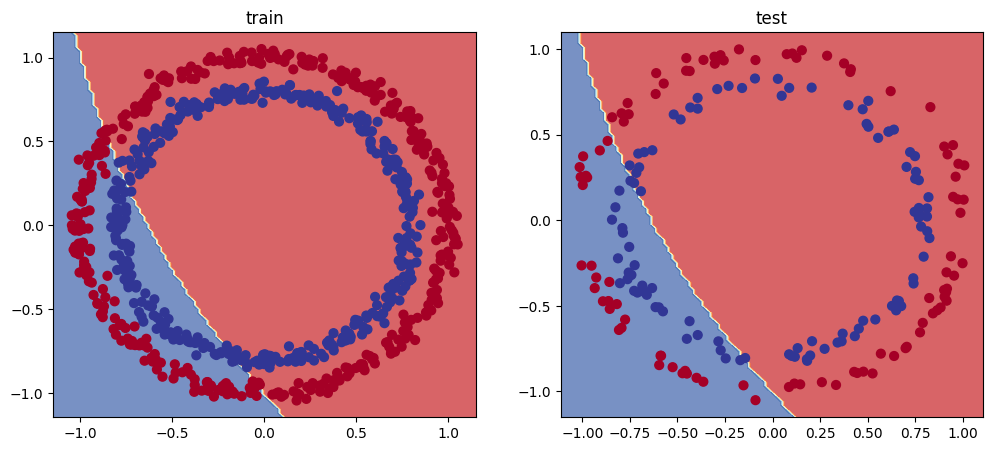

In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('train')
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title('test')
plot_decision_boundary(model_0, X_test, y_test)

***obs:*** model is only as good as a coin toss -> 50% correct predictions

##checking if our model learns by fitting it to a straight line mini-dataset

In [ ]:
#init params
weight = 0.7
bias = 0.3

#create mini-dataset
X_regression = torch.arange(0, 20, 0.2). unsqueeze(dim=1)
y_regression = weight * X_regression + bias

#check data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.2000],
         [0.4000],
         [0.6000],
         [0.8000]]),
 tensor([[0.3000],
         [0.4400],
         [0.5800],
         [0.7200],
         [0.8600]]))

In [ ]:
#train-test split
train_split = int(0.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression)

(80, 20)

In [ ]:
#build model
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#setup loss and optimizer funcs
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [ ]:
#training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  #Training
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)


  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.3f} | Test Loss: {test_loss:.3f}")

Epoch: 0 | Loss: 3.673 | Test Loss: 59.609
Epoch: 100 | Loss: 2.995 | Test Loss: 6.766
Epoch: 200 | Loss: 3.102 | Test Loss: 8.140
Epoch: 300 | Loss: 2.322 | Test Loss: 8.124
Epoch: 400 | Loss: 2.314 | Test Loss: 4.566
Epoch: 500 | Loss: 2.191 | Test Loss: 3.982
Epoch: 600 | Loss: 1.531 | Test Loss: 0.801
Epoch: 700 | Loss: 0.988 | Test Loss: 6.425
Epoch: 800 | Loss: 2.020 | Test Loss: 6.147
Epoch: 900 | Loss: 2.496 | Test Loss: 5.911


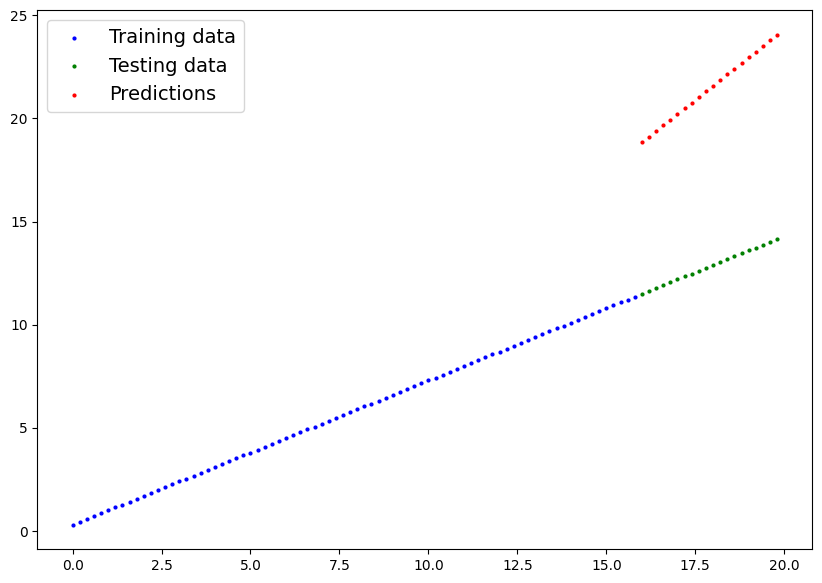

In [ ]:
#evaluation
model_2.eval()

with torch.inference_mode():
  y_pred = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=y_pred)

***obs:*** our model is learning, but it is not able to fit the circle dataset

##4.5 define model *(non-linear)*

In [ ]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() #non-linear activation

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [ ]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
#setup loss and optimizer funcs
loss_fn = nn.BCEWithLogitsLoss()

#setup optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.2)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

##4.6 train model *(non-linear)*

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  #Training
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #Testing
  model_3.eval()

  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                    y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.3f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.693, Acc: 49.88% | Test Loss: 0.692, Test Acc: 50.50%
Epoch: 100 | Loss: 0.690, Acc: 52.75% | Test Loss: 0.689, Test Acc: 56.00%
Epoch: 200 | Loss: 0.685, Acc: 54.12% | Test Loss: 0.684, Test Acc: 61.50%
Epoch: 300 | Loss: 0.675, Acc: 55.88% | Test Loss: 0.674, Test Acc: 63.50%
Epoch: 400 | Loss: 0.652, Acc: 61.50% | Test Loss: 0.650, Test Acc: 66.00%
Epoch: 500 | Loss: 0.574, Acc: 84.62% | Test Loss: 0.581, Test Acc: 82.00%
Epoch: 600 | Loss: 0.401, Acc: 95.25% | Test Loss: 0.414, Test Acc: 93.50%
Epoch: 700 | Loss: 0.361, Acc: 83.00% | Test Loss: 0.350, Test Acc: 82.00%
Epoch: 800 | Loss: 0.121, Acc: 99.38% | Test Loss: 0.126, Test Acc: 99.50%
Epoch: 900 | Loss: 0.075, Acc: 99.50% | Test Loss: 0.081, Test Acc: 99.50%


##4.7) model evaluation *(non-linear)*

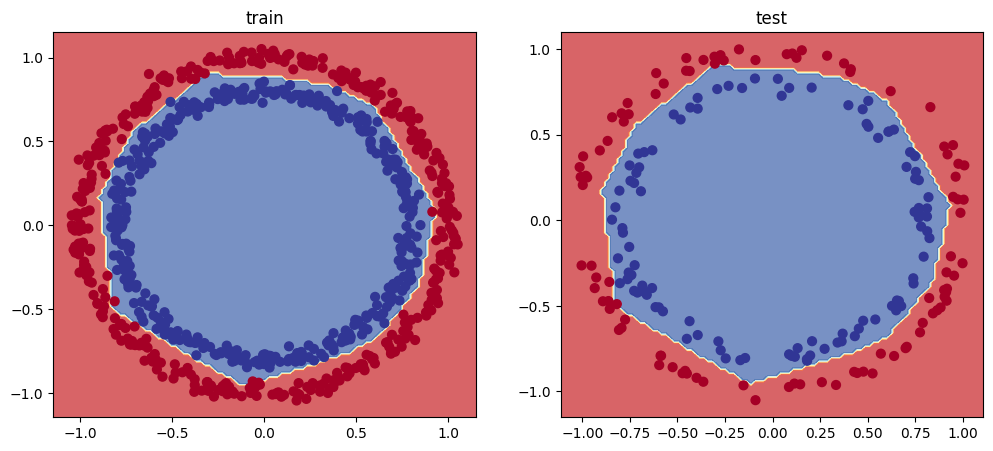

In [ ]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('train')
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1,2,2)
plt.title('test')
plot_decision_boundary(model_3, X_test, y_test)

##replicating non-linear activation funcs

In [ ]:
#create tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [ ]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

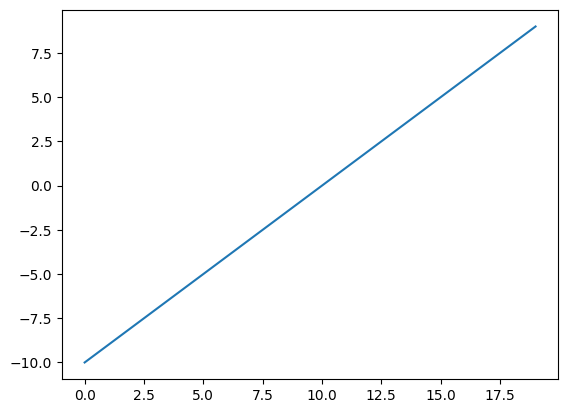

In [ ]:
plt.plot(A)

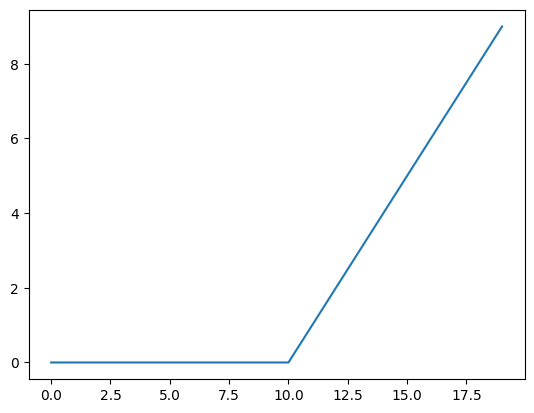

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
#creating our own relu
def my_relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

In [ ]:
my_relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

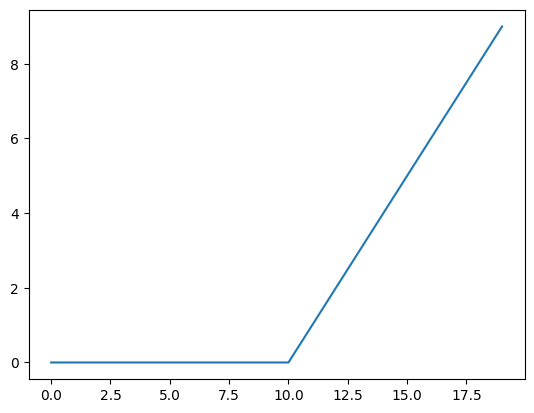

In [ ]:
plt.plot(my_relu(A))

#5. Putting it all together for a multi-class classification prob

##5.1) dataset

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

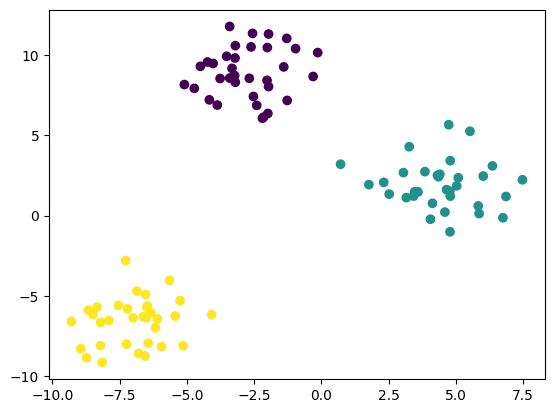

In [ ]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#1. create data
X_blob, y_blob = make_blobs(n_samples=100,
                            n_features=NUM_FEATURES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

#2. convert to tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#3. split into train and test set
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

#4. plot data
plt.scatter(X_blob[:, 0], X_blob[:,1], c=y_blob)

##5.2) model

In [ ]:
#device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [ ]:
model_4 = BlobModel(input_features=2,
                    output_features=3, #since we have only 3 unique classes
                    hidden_units=8)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [ ]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([80, 2]), tensor([2, 0, 1, 1, 1]))

In [ ]:
torch.unique(y_blob_train)

tensor([0, 1, 2])

##5.3) setup loss func and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

##5.4) output activation func

logits --`torch.softmax`→ pred probabs

In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:5]

tensor([[ 1.2934e+00,  4.9885e-01,  1.5249e+00],
        [ 1.8582e+00,  4.1882e-01,  2.1360e+00],
        [-1.1778e+00, -3.7560e-01, -1.3257e+00],
        [-1.0344e+00, -6.4145e-01, -1.2060e+00],
        [ 1.7399e-03, -1.4759e+00, -1.8408e-01]])

In [ ]:
y_blob_test[:5]

tensor([2, 2, 1, 1, 0])

In [ ]:
#convert model's logit outputs to prediction probabs
y_pred_probab = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probab[:5])

tensor([[ 1.2934e+00,  4.9885e-01,  1.5249e+00],
        [ 1.8582e+00,  4.1882e-01,  2.1360e+00],
        [-1.1778e+00, -3.7560e-01, -1.3257e+00],
        [-1.0344e+00, -6.4145e-01, -1.2060e+00],
        [ 1.7399e-03, -1.4759e+00, -1.8408e-01]])
tensor([[0.3687, 0.1666, 0.4647],
        [0.3910, 0.0927, 0.5163],
        [0.2443, 0.5449, 0.2107],
        [0.3009, 0.4457, 0.2534],
        [0.4858, 0.1108, 0.4034]])


In [ ]:
torch.argmax(y_pred_probab, dim=1)

tensor([2, 2, 1, 1, 0, 1, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 1])

In [ ]:
y_blob_test

tensor([2, 2, 1, 1, 0, 1, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 1])

##8.5 train model

In [ ]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  ###Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ###Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)


  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.3f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.666, Acc: 98.75% | Test Loss: 0.177, Test Acc: 100.00%
Epoch: 10 | Loss: 0.047, Acc: 98.75% | Test Loss: 0.023, Test Acc: 100.00%
Epoch: 20 | Loss: 0.027, Acc: 100.00% | Test Loss: 0.010, Test Acc: 100.00%
Epoch: 30 | Loss: 0.020, Acc: 100.00% | Test Loss: 0.006, Test Acc: 100.00%
Epoch: 40 | Loss: 0.016, Acc: 100.00% | Test Loss: 0.004, Test Acc: 100.00%
Epoch: 50 | Loss: 0.013, Acc: 100.00% | Test Loss: 0.003, Test Acc: 100.00%
Epoch: 60 | Loss: 0.012, Acc: 100.00% | Test Loss: 0.002, Test Acc: 100.00%
Epoch: 70 | Loss: 0.011, Acc: 100.00% | Test Loss: 0.002, Test Acc: 100.00%
Epoch: 80 | Loss: 0.010, Acc: 100.00% | Test Loss: 0.002, Test Acc: 100.00%
Epoch: 90 | Loss: 0.009, Acc: 100.00% | Test Loss: 0.001, Test Acc: 100.00%


##8.6) eval model

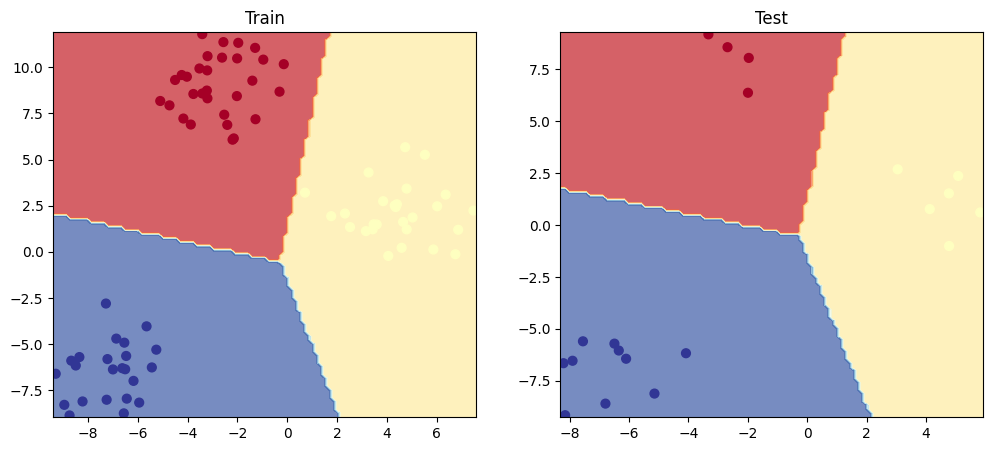

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
print(f"Accuracy: {accuracy_score(y_blob_test, test_pred)}")
print(f'Precision: {precision_score(y_blob_test, test_pred, average="weighted")}')
print(f'Recall: {recall_score(y_blob_test, test_pred, average="weighted")}')
print(f'F1 score: {f1_score(y_blob_test, test_pred, average="weighted")}')

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0


#Exercise 1: (Binary Classification)

##1) dataset

In [31]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.1)
X.shape, y.shape

((1000, 2), (1000,))

In [32]:
#convert to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

#train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape

(torch.Size([800, 2]), torch.Size([200, 2]))

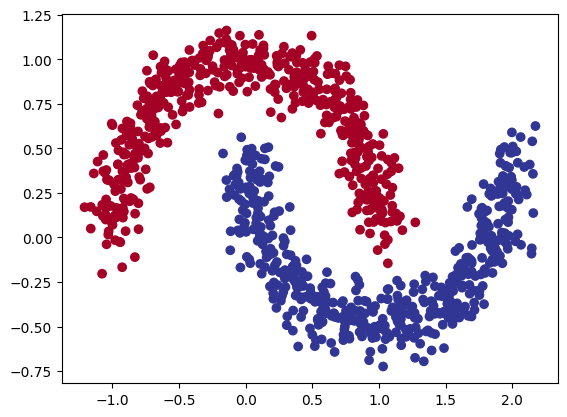

In [33]:
#visualization
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

##2) define model

In [34]:
#device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [35]:
class MoonModelV0(nn.Module):
  def __init__(self, inp_features, hidden_units, op_features):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=inp_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=op_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [36]:
model_5 = MoonModelV0(inp_features=2,
                      hidden_units=10,
                      op_features=1).to(device)

model_5

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [37]:
model_5.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[-0.3041, -0.0775],
                      [-0.5293,  0.6441],
                      [-0.5190,  0.3779],
                      [ 0.2485,  0.2298],
                      [-0.3823,  0.6427],
                      [ 0.1554,  0.0910],
                      [-0.6231,  0.2968],
                      [-0.1061, -0.3239],
                      [ 0.6074,  0.1576],
                      [-0.3912, -0.3579]])),
             ('linear_layer_stack.0.bias',
              tensor([-0.0338,  0.3948, -0.1807, -0.4035, -0.2421, -0.5283,  0.2522,  0.5473,
                      -0.6657,  0.1642])),
             ('linear_layer_stack.2.weight',
              tensor([[ 0.1634,  0.0573, -0.1126,  0.1651,  0.1662,  0.1182, -0.0556, -0.0837,
                        0.0338, -0.0559],
                      [-0.0942,  0.2021,  0.2718, -0.0313, -0.0708,  0.0046, -0.0189,  0.0760,
                        0.0886, -0.2872],
                      [-0.1167,  

##3) setup loss func and optimizer

In [38]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_5.parameters(),
                            lr=0.1)

In [39]:
!pip -q install torchmetrics

In [42]:
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=2).to(device)
accuracy_fn

MulticlassAccuracy()

##4) model training

In [43]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ###Training
  model_5.train()

  y_logits = model_5(X_train).squeeze()
  y_pred_probab = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probab)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ###Testing
  model_5.eval()
  with torch.inference_mode():
    test_logits = model_5(X_test).squeeze()
    test_pred_probab = torch.sigmoid(test_logits)
    test_pred = torch.round(test_pred_probab)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)


  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.3f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.691, Acc: 0.50% | Test Loss: 0.686, Test Acc: 0.52%
Epoch: 50 | Loss: 0.557, Acc: 0.83% | Test Loss: 0.546, Test Acc: 0.84%
Epoch: 100 | Loss: 0.366, Acc: 0.86% | Test Loss: 0.355, Test Acc: 0.86%
Epoch: 150 | Loss: 0.273, Acc: 0.88% | Test Loss: 0.270, Test Acc: 0.87%
Epoch: 200 | Loss: 0.231, Acc: 0.90% | Test Loss: 0.231, Test Acc: 0.89%
Epoch: 250 | Loss: 0.206, Acc: 0.91% | Test Loss: 0.209, Test Acc: 0.89%
Epoch: 300 | Loss: 0.186, Acc: 0.91% | Test Loss: 0.190, Test Acc: 0.90%
Epoch: 350 | Loss: 0.166, Acc: 0.92% | Test Loss: 0.172, Test Acc: 0.92%
Epoch: 400 | Loss: 0.146, Acc: 0.93% | Test Loss: 0.153, Test Acc: 0.93%
Epoch: 450 | Loss: 0.125, Acc: 0.95% | Test Loss: 0.132, Test Acc: 0.95%
Epoch: 500 | Loss: 0.105, Acc: 0.96% | Test Loss: 0.111, Test Acc: 0.97%
Epoch: 550 | Loss: 0.086, Acc: 0.97% | Test Loss: 0.092, Test Acc: 0.98%
Epoch: 600 | Loss: 0.071, Acc: 0.99% | Test Loss: 0.075, Test Acc: 0.98%
Epoch: 650 | Loss: 0.058, Acc: 0.99% | Test Loss: 0.06

##5) model evaluation

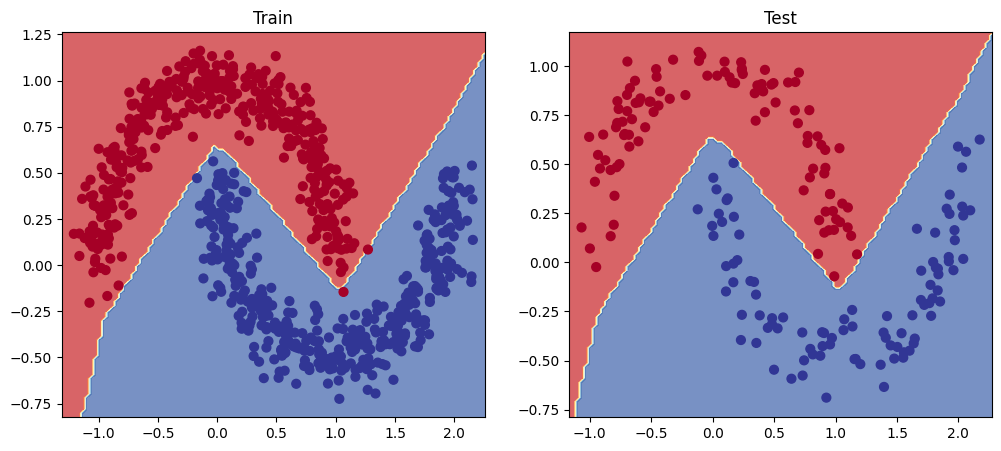

In [46]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_5, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_5, X_test, y_test)

#Exercise 2: replicate Tanh activation function

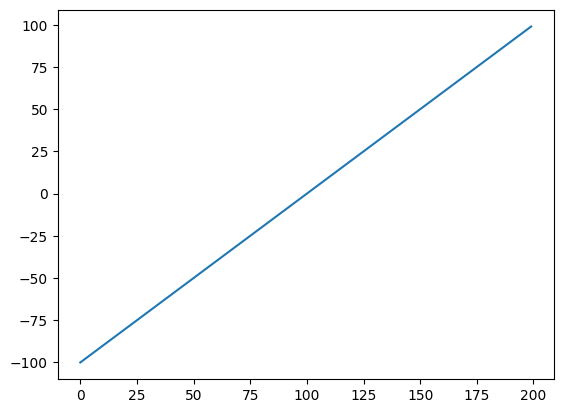

In [ ]:
tensr_A = torch.arange(-100, 100, 1)
plt.plot(tensr_A)

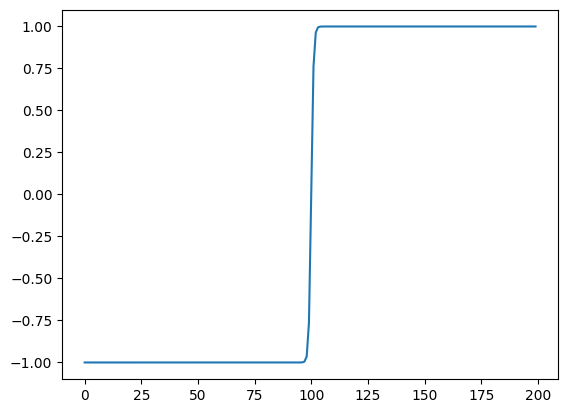

In [ ]:
plt.plot(torch.tanh(tensr_A))

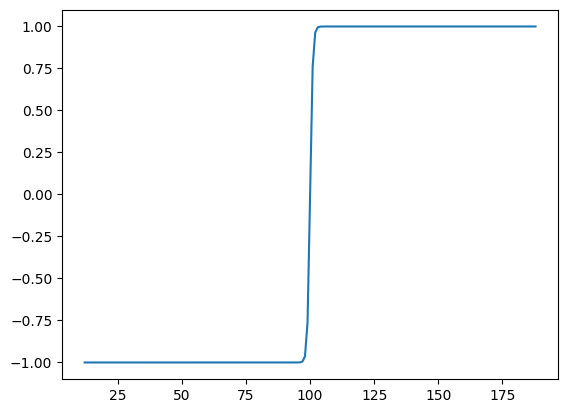

In [ ]:
def my_tanh(x):
  return (torch.exp(x) - torch.exp(-x))/ (torch.exp(x) + torch.exp(-x))

plt.plot(my_tanh(tensr_A))

#Exercise 3: Multi-class classification

##1) dataset

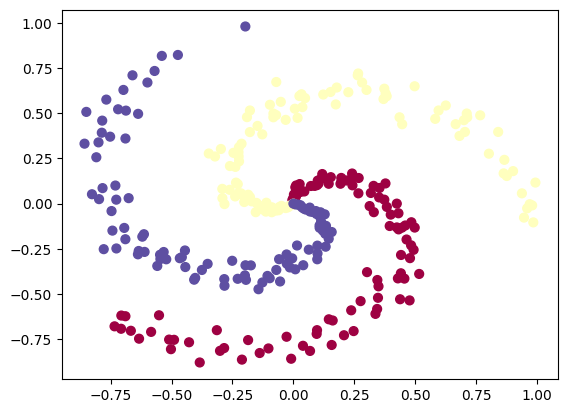

In [47]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [48]:
#convert to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [49]:
#train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape

(torch.Size([240, 2]), torch.Size([60, 2]))

##2) define model

In [50]:
#device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [67]:
class SpiralModelV0(nn.Module):
  def __init__(self, inp_features, hidden_units, op_features):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=inp_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=op_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [68]:
model_6 = SpiralModelV0(2, 14, 3).to(device)
model_6

SpiralModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=14, bias=True)
    (1): ReLU()
    (2): Linear(in_features=14, out_features=14, bias=True)
    (3): ReLU()
    (4): Linear(in_features=14, out_features=3, bias=True)
  )
)

In [69]:
model_6.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252]])),
             ('linear_layer_stack.0.bias',
              tensor([ 0.0667, -0.6984,  0.6386, -0.6007,  0.5459,  0.1177, -0.2296,  0.4370,
                       0.1102,  0.5713,  0.0773, -0.2230,  0.1900, -0.1918])),
             ('linear_layer_stack.2.weight',
              tensor([[ 0.1125,  0.2386,  0.1545, -0.1168,  0.1543,  0.0478,  0.1357, -0.1629,
        

##3) setup loss_fn, optimizer, accuracy_fn and device agnostic data

In [70]:
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_6.parameters(),
                            lr=0.1)

In [71]:
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=3).to(device)
accuracy_fn

MulticlassAccuracy()

In [72]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

##4) model training

In [73]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  ###Training
  model_6.train()

  y_logits = model_6(X_train).squeeze()
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_pred, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ###Testing
  model_6.eval()
  with torch.inference_mode():
    test_logits = model_6(X_test).squeeze()
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(test_pred, y_test)


  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.3f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.110, Acc: 0.33% | Test Loss: 1.095, Test Acc: 0.35%
Epoch: 100 | Loss: 0.928, Acc: 0.55% | Test Loss: 0.955, Test Acc: 0.45%
Epoch: 200 | Loss: 0.690, Acc: 0.58% | Test Loss: 0.762, Test Acc: 0.50%
Epoch: 300 | Loss: 0.619, Acc: 0.62% | Test Loss: 0.699, Test Acc: 0.58%
Epoch: 400 | Loss: 0.554, Acc: 0.68% | Test Loss: 0.636, Test Acc: 0.60%
Epoch: 500 | Loss: 0.475, Acc: 0.73% | Test Loss: 0.551, Test Acc: 0.68%
Epoch: 600 | Loss: 0.388, Acc: 0.81% | Test Loss: 0.456, Test Acc: 0.73%
Epoch: 700 | Loss: 0.313, Acc: 0.88% | Test Loss: 0.372, Test Acc: 0.82%
Epoch: 800 | Loss: 0.257, Acc: 0.91% | Test Loss: 0.309, Test Acc: 0.82%
Epoch: 900 | Loss: 0.215, Acc: 0.92% | Test Loss: 0.264, Test Acc: 0.92%


##5) model evaluation

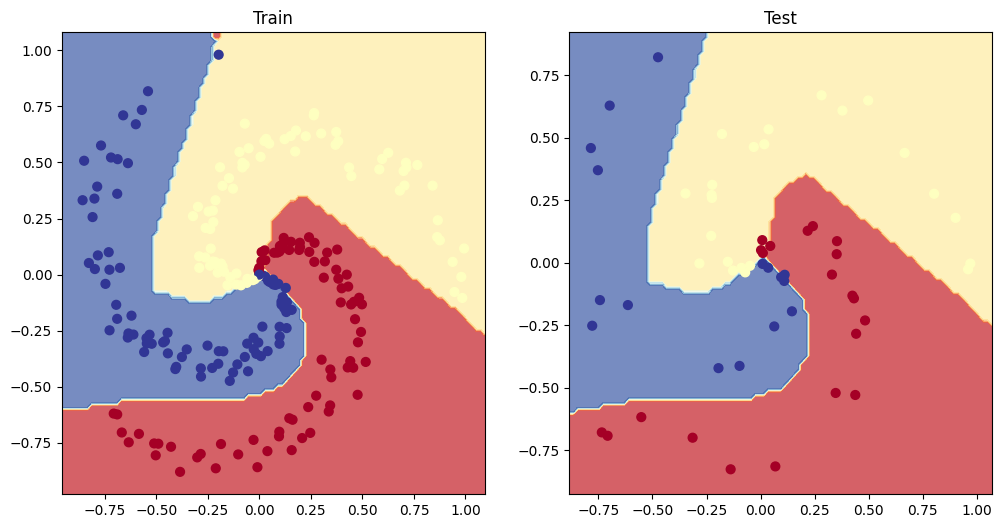

In [74]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_6, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_6, X_test, y_test)